# IMPORTANT:
Before you start coding, you must save a copy of this notebook to your own Google Drive. See `File > Save a copy in Drive`.

If you forget to do this, your changes will be lost at the end of the session. If changes are being saved, you should see `All Changes Saved` to the right of the `Help` menu.

You are free to download the .ipynb file and edit it using some other tool if you like. You do not need to use Google Colab if you are more familiar with another Jupyter environment.




# Quick Introduction to CVXPY

[CVXPY](http://www.cvxpy.org/en/latest/index.html) is a Python-embedded modeling language for convex optimization problems. It allows you to express your problem in a natural way that follows the math, rather than in the restrictive standard form required by solvers.

In this Jupyter notebook, we will see some examples on how to solve optimization problems using cvxpy.

## A Linear Program

Let's start with a simple example of a Linear Program, i.e., an optimization problem with a linear objective and linear inequality constraints.

$$
\begin{align}
\max  \; & 140x + 235y\\
\textrm{s.t.}\; & x + y \leq 180,\\
 & x + 2y \leq 240,\\
 & 3x + y \leq 300\\
 & x \geq 0, y \geq 0.
\end{align}
$$

Here is how you code this up and solve it using CVXPY.

In [ ]:
import cvxpy as cp
import numpy

# Create two scalar optimization variables
x = cp.Variable()
y = cp.Variable()

# Create constraints
constraints = [x >= 0,
               y >= 0,
               x + y <= 180,
               x + 2*y <= 240,
               3 * x + y <= 300]
#constraints.append(x**2+2*y**2 >= 1)

# Form objective
obj = cp.Maximize(140*x +235*y)

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()

print(f"status: {prob.status}")
print(f"optimal value: {prob.value:.3f}")
print(f"optimal var: x = {x.value:.3f}, y = {y.value:.3f}")

status: optimal
optimal value: 29820.000
optimal var: x = 72.000, y = 84.000


CVXPY makes it easy to change the problem formulation. For example, we can add the constraint
$$
x^2 + 2 y^2 \leq 1
$$
and solve the problem again.

In [ ]:
constraints.append(x**2+2*y**2 <= 1)

prob = cp.Problem(obj, constraints)
prob.solve()

print(f"status: {prob.status}")
print(f"optimal value: {prob.value:.3f}")
print(f"optimal var: x = {x.value:.3f}, y = {y.value:.3f}")

status: optimal
optimal value: 217.284
optimal var: x = 0.644, y = 0.541


What happens when we flip the sign of this additional quadratic constraint? Check it out. How do you explain it?

# An infeasible problem

Here is a simple 2-D problem:
$$
\begin{align}
\min & \; x+y\\
\textrm{s.t.} &\;  x+y \leq -5\\
&\; x^2 + y^2 \leq 1 \\
\end{align}
$$

Can you explain the output of the solver below? What happens as you change the right hand side of the second constraint?

In [ ]:
# An infeasible problem
x = cp.Variable()
y = cp.Variable()

obj = cp.Minimize(x+y)
constraints = [x + y <= -5, x**2 + y**2 <= 1
]
prob = cp.Problem(obj, constraints)
prob.solve() # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)

status: infeasible
optimal value inf
optimal var None


# Disciplined Convex Programming

http://dcp.stanford.edu/home

# Min s-t distance

A problem we saw in class was minimum distances. We studied a number of algorithms for different kinds of graphs; BFS for unweighted graphs, Dijkstra's algorithm for graophs with positive weights and Bellman-Ford for graphs with no negative cycles. Now we can write it as a linear program.

First we will load [Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) from Python's `networkx` library.

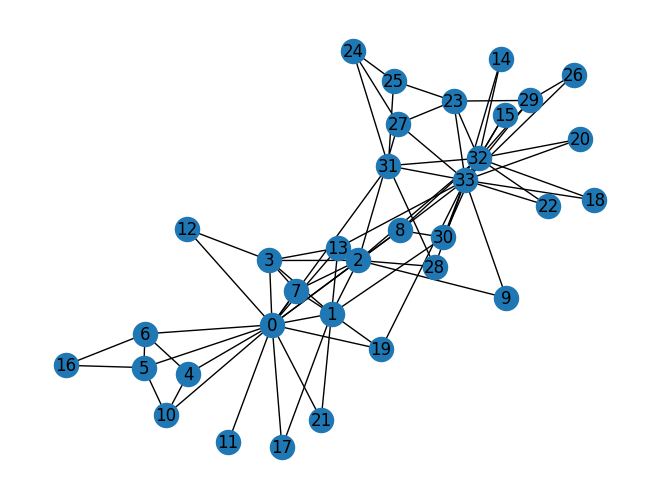

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

np.random.seed(2)
G = nx.karate_club_graph()
n = nx.number_of_nodes(G)
m = nx.number_of_edges(G)
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=True)

We want to maximize the distance of $t$ with the constraint that we can't stretch edges.

\begin{align*}
\max & \; d_t \\
\text{s.t.}\ & |d_u - d_v| \leq 1 &\ \forall \{u, v\} \in E \\
& d_s = 0
\end{align*}

In [ ]:
distance = cp.Variable(n, nonneg=True)
a = cp.Variable(nonneg=True)

s = 0
t = 33

constraints = [distance[s] == 0]

# TODO: Formulate the constraints as above
...
for u, v in G.edges():
  constraints.append(cp.abs(distance[u]-distance[v]) <= 1)

obj = cp.Maximize(distance[t]) # TODO: Write the objective function
prob = cp.Problem(obj, constraints)
prob.solve()
print("status:", prob.status)
print(f"optimal value: {prob.value:.6f}")
print("optimal values:")
# for node in G:
#     print(f"{node:2d}: {distance[node].value:.3f}")


status: optimal
optimal value: 2.000000
optimal values:


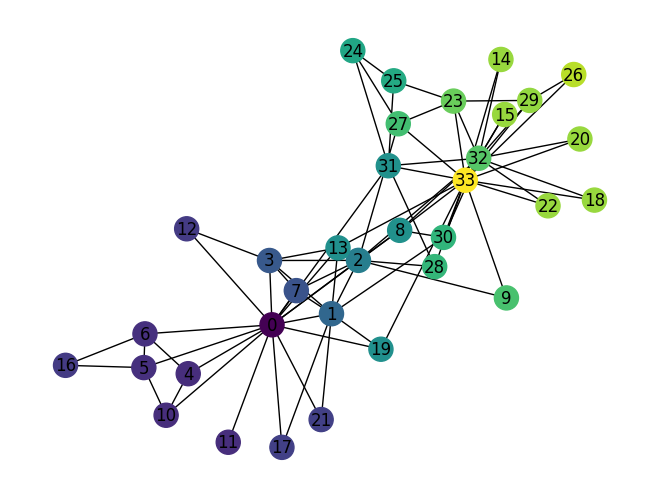

In [ ]:
nx.draw(G, pos=pos, with_labels=True, node_color=distance.value / distance[t].value)

## Maximum flow

We can also use `cvxpy` to formulate maximum flow on a graph. The constraints are that every edge cannot carry more than its capacity and except for $s$ and $t$, in all other nodes there should be flow conservation. The karate graph is undirected, but we can model each undirected $\{u, v\}$ edge as a pair of directed edges $(u, v)$ and $(v, u)$ going in opposite directions.

\begin{align*}
\max & \sum_{(v, t)} f_{(v, t)} \\
\text{s.t.}\ & 0 \leq f_e \leq 1, &\ \forall e \in E \\
& \sum_{(u, v)\ \in E} f_{(u, v)} = \sum_{(v, w)\ \in E} f_{(v, w)}, &\ \forall v \not \in \{s, t\}
\end{align*}

In [ ]:
def maxFlow(G, s, t):
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)

    edge_var = cp.Variable(2 * m)               # Think of an undirected edge as two directed edges going in opposite directions



    # Note - you can organize the variables however you want after cvxpy creates them.
    # It may make more sense to place them in 2 seperate lists based on direction. Alternatively,
    # you can associate each one with an edge using a dictionary.

    # TODO: Write the constraints as above
    constraints = []

    # The flow going through each edge must in [0, 1]
    for edge in range(2 * m):
      constraints.append(edge_var[edge] >= 0)
      constraints.append(edge_var[edge] <= 1)

    # The sum of the flows going in and out of each
    # node other than s and t must be 0
    flow = {}
    index = 0
    for u,v in G.edges():
      flow[(u,v)] = index
      index += 1
      flow[(v,u)] = index
      index += 1
    for node in G.nodes():
      if node not in [s,t]:
        flow_in = sum(edge_var[flow[neighbor, node]] for neighbor in G[node])
        flow_out = sum(edge_var[flow[node, neighbor]] for neighbor in G[node])
        constraints.append(flow_in == flow_out)
    obj = cp.Maximize(sum(edge_var[flow[(v,t)]] for v in G[t]))                                      # TODO: The objective is to maximize the net flow going in to t
    prob = cp.Problem(obj, constraints)
    prob.solve()
    print("status:", prob.status)
    print("optimal value", prob.value)

    return prob.value

# Test on the Karate Club graph
maxFlow(G, 0, 33)

status: optimal
optimal value 16.99999999964296


16.99999999964296

In [ ]:
# Displays the graph using the results from the first m edges. Depending on how
# You organized your 2n variables, you may want to tweak this to get a more useful
# visualization. Feel free to ignore.
# nx.draw(G, pos=pos, with_labels=True, edge_color=np.abs(edge_var.value[0:m]), edge_cmap=plt.cm.Blues)

# uncommonted the code to check the result


# def maxFlow(G, s, t):
#     n = nx.number_of_nodes(G)
#     m = nx.number_of_edges(G)

#     edge_var = cp.Variable(2 * m)               # Think of an undirected edge as two directed edges going in opposite directions



#     # Note - you can organize the variables however you want after cvxpy creates them.
#     # It may make more sense to place them in 2 seperate lists based on direction. Alternatively,
#     # you can associate each one with an edge using a dictionary.

#     # TODO: Write the constraints as above
#     constraints = []

#     # The flow going through each edge must in [0, 1]
#     for edge in range(2 * m):
#       constraints.append(edge_var[edge] >= 0)
#       constraints.append(edge_var[edge] <= 1)

#     # The sum of the flows going in and out of each
#     # node other than s and t must be 0
#     flow = {}
#     index = 0
#     for u,v in G.edges():
#       flow[(u,v)] = index
#       index += 1
#       flow[(v,u)] = index
#       index += 1
#     for node in G.nodes():
#       if node not in [s,t]:
#         flow_in = sum(edge_var[flow[neighbor, node]] for neighbor in G[node])
#         flow_out = sum(edge_var[flow[node, neighbor]] for neighbor in G[node])
#         constraints.append(flow_in == flow_out)
#     obj = cp.Maximize(sum(edge_var[flow[(v,t)]] for v in G[t]))                                      # TODO: The objective is to maximize the net flow going in to t
#     prob = cp.Problem(obj, constraints)
#     prob.solve()
#     nx.draw(G, pos=pos, with_labels=True, edge_color=np.abs(edge_var.value[0:m]), edge_cmap=plt.cm.Blues)
#     print("status:", prob.status)
#     print("optimal value", prob.value)

#     return prob.value

# # Test on the Karate Club graph
# maxFlow(G, 0, 33)
# plt.show()

## Linear Programming vs Dedicated Algorithms

You already expressed $s-t$ minimum distance and maximum $s-t$ flow. If we can express these problems as LPs, then why did we spend a quarter of this class learning specific algorithms to solve them?

In this section you will use the function you wrote on a random graph to compute maximum $s-t$ flow and then compare the running time with `networkx`'s built in Max Flow algorithm.

First you need to create a $G(n, p)$ graph and then find the maximum flow between nodes $0$ and $n-1$.

In [ ]:
n = 100
p = 2 * n * np.log(n)
Gnp = nx.fast_gnp_random_graph(n, p)
nx.set_edge_attributes(Gnp, 1, 'capacity')


%timeit flow = maxFlow(Gnp, 0, n - 1)
%timeit flow = nx.maximum_flow_value(Gnp, 0, n - 1)

status: optimal
optimal value 98.99999999993427
status: optimal
optimal value 98.99999999993427
status: optimal
optimal value 98.99999999993427
status: optimal
optimal value 98.99999999993427
status: optimal
optimal value 98.99999999993427
status: optimal
optimal value 98.99999999993427
status: optimal
optimal value 98.99999999993427
status: optimal
optimal value 98.99999999993427
42.6 s ± 2.54 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
33.1 ms ± 961 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The fraction of time taken between Linear Programming and `networkx` is: **TODO**